# Tomo_1_index
## Tomographic indexing notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This means your peaks have been merged across omega (rotation of the sample around the rotation axis) and dty (translation of the sample across the beam).  

This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

The notebooks are written with all the parameters in the first cell.
We will see how to tune these parameters along the notebook.

For now, change : 
1. the dataset name (`dset_path`)
2. the phase name (`phase_str`)

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# which phase to index
phase_str = 'Fe'
# peak filtration parameters
min_frames_per_peak = 0
cf_strong_frac = 0.9939
cf_strong_dsmax = 1.594
cf_strong_dstol = 0.005

# indexing parameters
# we have to choose which rings we want to generate orientations on
# generally we want two or three low-multiplicity rings that are isolated from other phases
# take a look at the ring assignment output from a few cells above, and choose two or three
rings_for_gen = [0, 1, 3]
# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 1, 2, 3, 4]
# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.07]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.7]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

peak_assign_tol = 0.05

# EXPERTS: Can specify par_file as a parameter if you want
par_file = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/pars/pars.json'

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )
# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [3]:
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.peakselect import select_ring_peaks_by_intensity
import ImageD11.nbGui.nb_utils as utils

# %matplotlib ipympl

# Load the data
1. The dataset
2. The parameters (from calibration)
3. The phases
4. The segmented peaks

## Dataset

In [4]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Parameters
Specify the path to the parameter file.

You can optionally set up some default parameters for either an Eiger or Frelon detector like so:
```python
from ImageD11.parameters import AnalysisSchema
asc = AnalysisSchema.from_default(detector='eiger')  # or detector='frelon'
asc.save('./pars.json')
```
Please note in this case that you will still have to update the `geometry.par` values accordingly for your experiment.  
If you haven't already, you should run one of the calibration notebooks to determine these.

In [5]:
if par_file is None:
    # par_file = os.path.join(ds.analysisroot, 'pars.json')
    par_file = '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/pars/pars.json'
ds.parfile = par_file
ds.save()

## Phases

All the phases should be specified in the parameter file.
We can access the unit cells via `ds.phases.unitcells`

In [6]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

The parameters of the phase to index are printed below

In [7]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks
Loading the peaks that have beem segmented in @@@ref to 0_segmentation@@@ as a columnfile (*cf_4d*)

In [8]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)
if not os.path.exists(ds.col4dfile):
    # save the 4D peaks to file so we don't have to spatially correct them again
    ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


### Optionally remove some noisy peaks
You can filter peaks that do not appear on a minimum number of frame.
`min_frames_per_peaks = 0`

In [9]:
if min_frames_per_peak > 0:
    cf_4d.filter(cf_4d['npk2d'] > min_frames_per_peak)

# Visualise data

## Peaks in function of d*
Now all the peaks are plotted in function of $\eta$ and $d^{*}$. The theoretical reflections of the major phase are overlaid as red straight lines. 

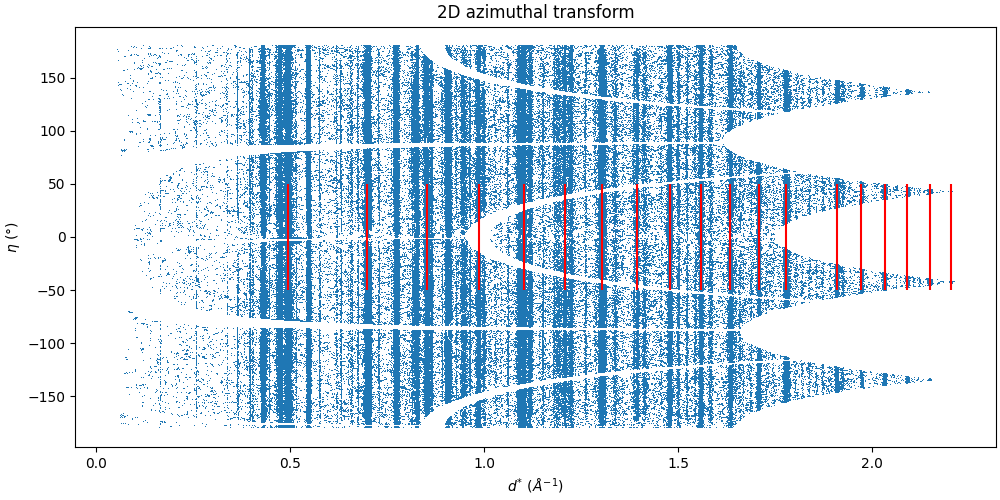

In [10]:
skip = 1  # we can skip peaks to speed up plotting if needed
ucell.makerings(cf_4d.ds.max())
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(cf_4d.ds[::skip], cf_4d.eta[::skip], ',')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
plt.show()

## Sinogram
This visualisation shows where the peaks appear in the real space (rotation $\omega$ and translation $dty$ stages)

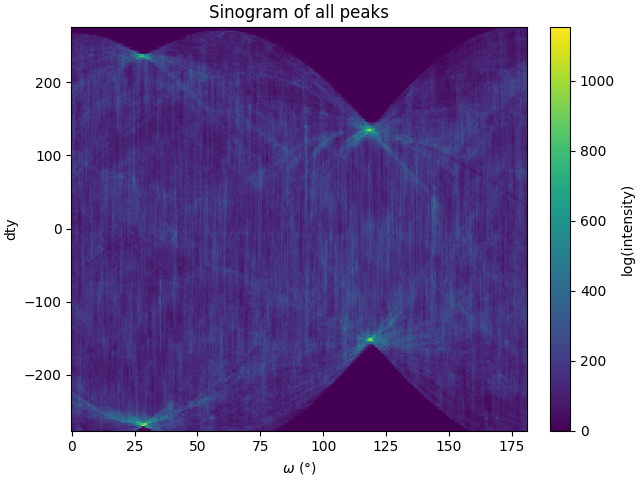

In [11]:
fig, ax = plt.subplots(layout='constrained')
im, om_edges, dty_edges = ds.sinohist(np.log(ds.pk2d['sum_intensity']), ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
pcm = ax.pcolormesh(om_edges, dty_edges, im.T)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Sinogram of all peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

# Filtration

Here we are filtering our peaks (`cf_4d`) to select only the strongest ones for indexing purposes only!  

1. We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
2. We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.

- `cf_strong_dstol`: The $d^{*}$ tolerance ; it is the tolerance around the predicted reflection for which a peak will be kept for indexing.  
- `cf_strong_dsmax`: The maximum $d^{*}$ value ; peaks that have a $d^{*}$ below this value will be kept for indexing. 6-8 rings max are normally sufficient.   
- `cf_strong_frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

- `cf_strong_dstol = 0.005`
- `cf_strong_dsmax = 1.594`
- `cf_strong_frac = 0.9939`

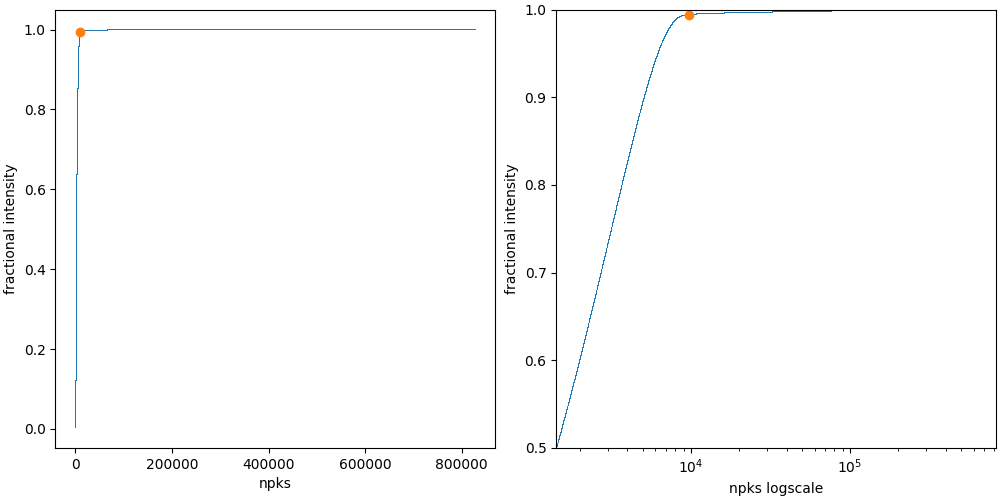

Filtered 9683 peaks from 1486660


In [12]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)

All the peaks are plotted as a function of their intensity, and the strongest ones that are kept for indexing are highlighted in orange.
By zooming aroung one single peak, it is possible to refine the value of `cf_strong_dstol`.

If the peaks do not perfectly sit on the theoretical reflections, there can be different reasons : 
- the calibration is not correct (more likely if the peaks are very far from the theoretical ones).
- the sample cell parameters are not accurate (if you slightly change the value in the parameter file, you will see the red line moving). Refined parameters will be obtained at the end of the notebook.

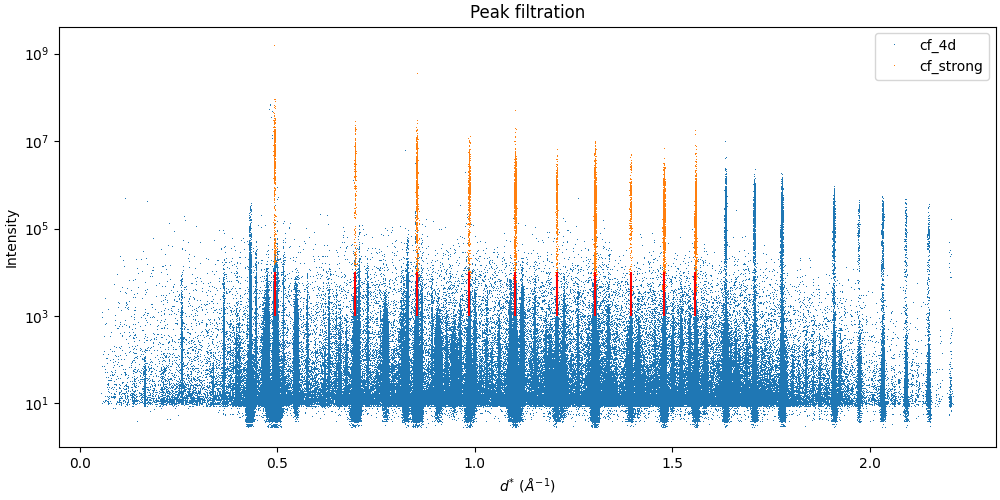

In [13]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment
For the current phase cell parameters and the selected strong peaks (*cf_strong*), the multiplicity of each reflection and the number of peaks to index is prompted.

In [14]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, ucell)
indexer.ds_tol = cf_strong_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.28184804 -0.32809819  1.32491734]
 [-0.21173451 -1.14213192  0.32422539]
 [-0.02789417  0.4136396  -0.27306202]
 ...
 [-0.04287389  0.86938759 -0.46276102]
 [-0.02437961  0.76196377  0.38485489]
 [-0.04031814  0.39314797 -0.29272477]] (9683, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.562827
info: Ring assignment array shape (9683,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 9   ( -2,  0, -4)   24   1189       0     1189    48     24  25.62
info: Ring 8   ( -1, -1, -4)   36   1689       0     1689    46     36  24.29
info: Ring 7   (  0, -4,  0)    6    306       0      306    50      6  22.88
info: Ring 6   ( -2, -3, -1)   48   2263       0     2263    46     48  21.38
info: Ring 5   ( -2, -2, -2)    8    414       0      414    51      8  19.78
info: Ring 4   ( -1,  0, -3)   24   1161       0     1161    47     24  18.04
info: Ring 3   ( -2,  0, -2)   12    610       0      610    50     12  16.

All the strong peaks are assigned to a theoretical ring.

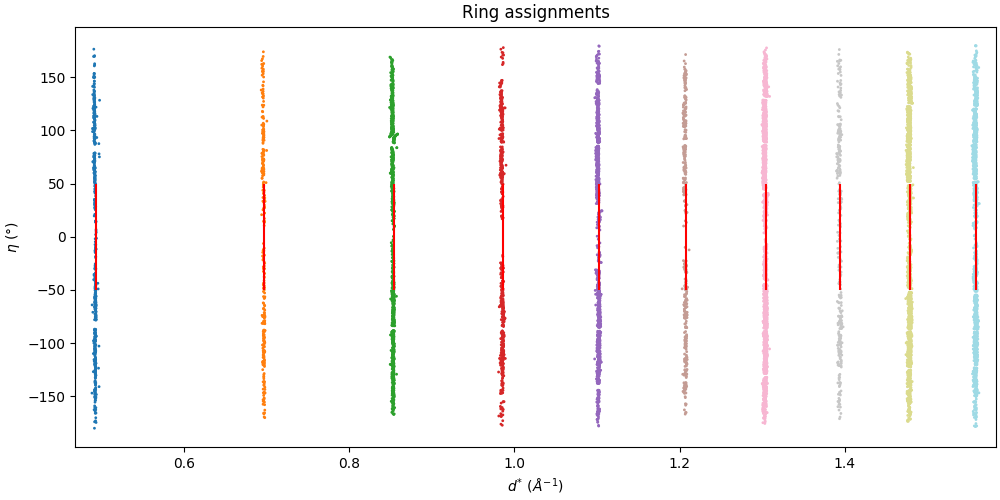

In [15]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(ucell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
plt.show()

Seven parameters are tunable for this step : 
- `cf_strong_dstol` has been defined earlier,
- `rings_for_gen` is a list of integeres. It refers to the theoretical reflections that will be use to generate grain candidates. For a fast indexing, it is smarter to select rings with a low multiplicity.
- `rings_for_scoring` is a list of integers. It refers to the theoretical reflections that will be use to score the grain candidates. `rings_for_gen` has to be included in `rings_for_scoring`.
- `hkl_tols_seq` is a list of floats. It refers to the tolerances around the *hkl* to assess if a peak belongs to a grain or not. 
- `fracs` is a list of floats. It refers to the number of peaks a grain needs to have to accept it, as a fraction of the number of peaks a real grain is expected to have. 
- `cosine_tol` is a float number. @@@ what is this @@@
- `max_grains` is an integer. The maximum number of grains that can be indexed (it highly unlikely to have more than 1000 grains in the major phase today 06/2025).

The indexing will be executed in a loop such as : 
```
for f in fracs:
    for khl in hkl_tols_seq:
        Do_indexing
```
Note that if $n$ peaks are assigned to a grain during the first round of indexing, these peaks will be removed from all the other indexing steps. 
It is possible to estimate the number of expected grains with the cross section and the average grain size.

In [16]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
grains, indexer = utils.do_index(cf=cf_strong, 
                                 unitcell=ds.phases.unitcells[phase_str],
                                 dstol=cf_strong_dstol,
                                 forgen=rings_for_gen,
                                 foridx=rings_for_scoring,
                                 hkl_tols=hkl_tols_seq,
                                 fracs=fracs,
                                 cosine_tol=cosine_tol,
                                 max_grains=max_grains)
for ginc, g in enumerate(grains):
    g.gid = ginc
print(f'Found {len(grains)} grains!')

78 peaks expected
Trying these rings (counts, multiplicity, ring number): [(322, 6, 1), (551, 12, 0), (610, 12, 3)]
0.9 0.01 5
0.9 0.02 10
0.9 0.03 18
0.9 0.04 25
0.9 0.07 44
0.7 0.01 44
0.7 0.02 46
0.7 0.03 47
0.7 0.04 47
0.7 0.07 51
Found 51 grains!


## Results

Let's take a look at the results. Firstly, it is possible to compute the average cell parameters of all indexed grains. 
If the average parameters of the unit cell are far from the one used to do the indexing, it is possible to update them in the parameter file, and redo the indexing from scratch.

Median unit cell: [ 2.86930373  2.87133494  2.87279718 89.96617941 90.00986951 90.06375655]


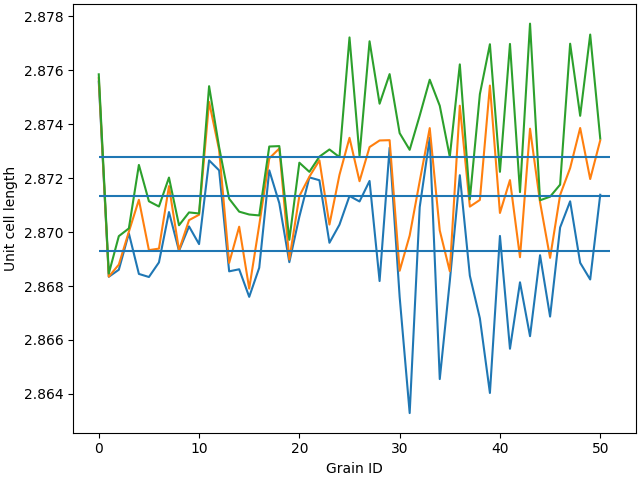

In [17]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel='Grain ID', ylabel='Unit cell length')
plt.show()

Secondly, it is possible to assign the peaks to every grain found. `peak_assign_tol` defines the tolerance within which a peak is assigned to a grain or not.

In [19]:
utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 51 grains


  0%|          | 0/51 [00:00<?, ?it/s]

Let's plot various informations : 

- (a) shows the hkl error of all the indexed peaks. A small bump at the beginning is usually a good sign and means you can be confident in the indexed grains. 
- (b) shows the sinograms of all indexed grains.
- (c) shows the sinograms of all unassigned peaks. In a perfect experiment, this plot is empty and all peaks are assigned to grains. If too many peaks are unassigned you may want to change the indexing parameters (decrease `fracs`, increase `hkl_tols_seq`, change `rings_for_gen`).
- (d) shows the intensity of all assigned peaks.
- (e) shows the intensity of all unassigned peaks.
- (f) shows an histogram of all grains, and the number of peaks that have been assigned to each. The more peaks are assigned to a grain, the more "true" it is.

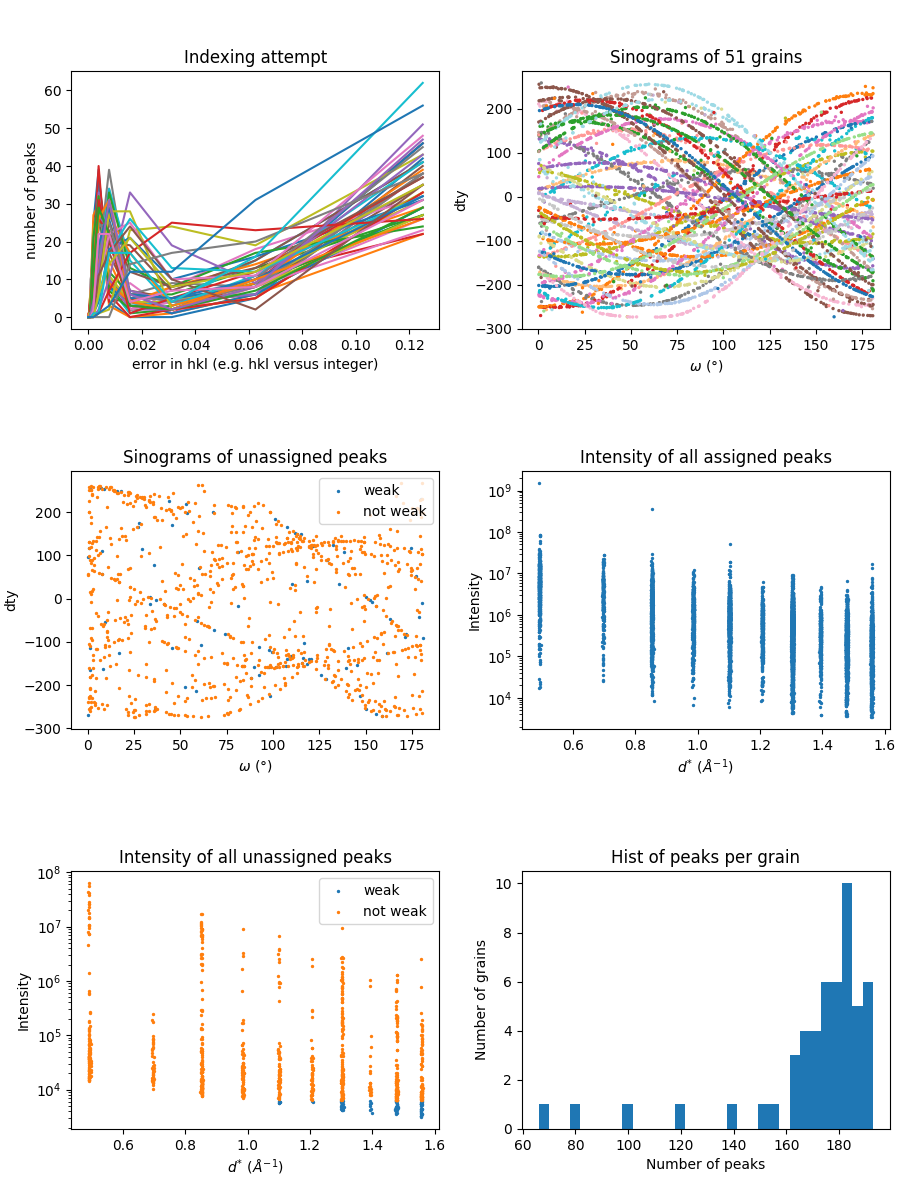

In [20]:
utils.plot_index_results(indexer, cf_strong, 'Indexing attempt')

Finally, it is possible to visualize some sinograms individually. Here the impact of `peak_assign_tol` is clearly visible. When it is increased too much, more noisy peaks start to appear on the sinogram. 


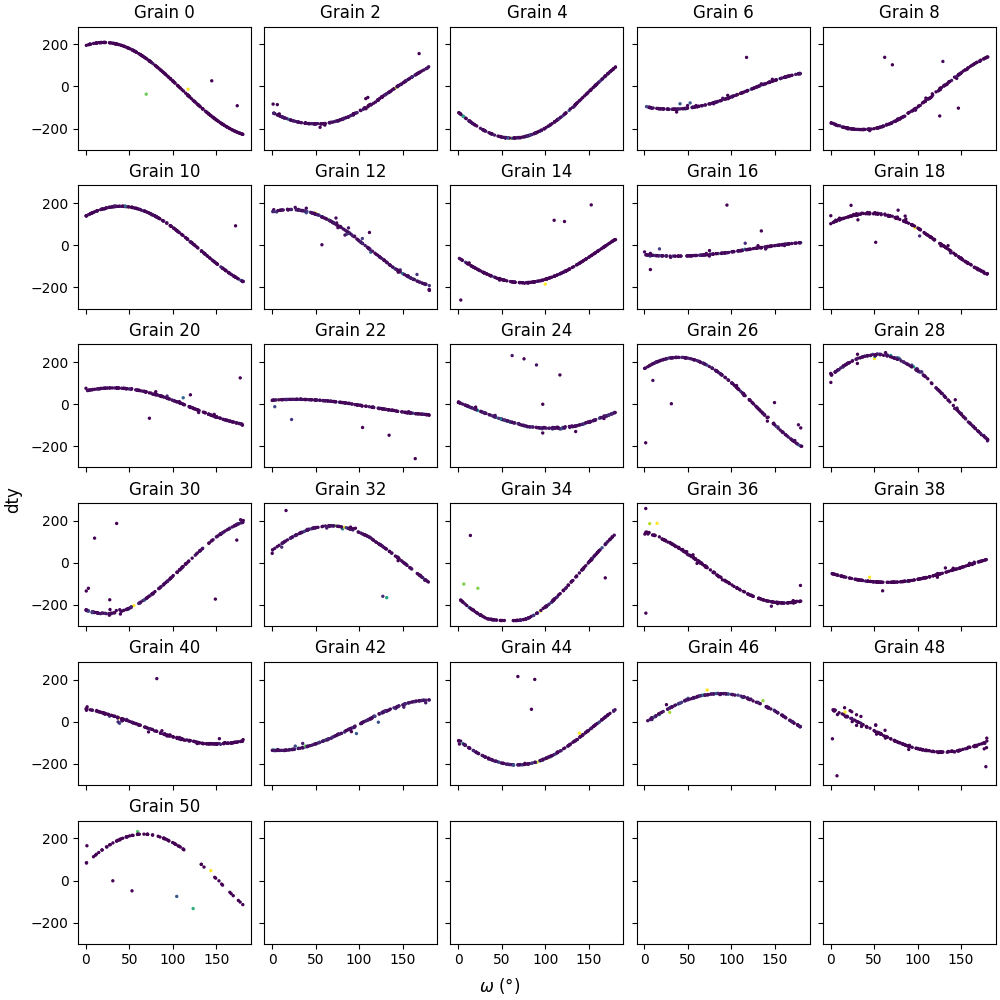

In [21]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Export data

You can not save new indexed grains if there are some existing ones. This cell deletes all existing grains of the phase `phase_str` from the *h5* grain file.

In [22]:
from ImageD11.forward_model import io
io.delete_group_from_h5(ds.grainsfile, group_name = phase_str)

Save the data in an *h5* grain file.

In [24]:
ds.save_grains_to_disk(grains, phase_name=phase_str)
ds.save()